# Optimization

- [Least squares](#Least-squares)
- [Gradient descent](#Gradient-descent)
- [Constraint optimization](#Constraint-optimization)
- [Global optimization](#Global-optimization)

Start with describing the problem, like here

- https://scaron.info/blog/linear-programming-in-python-with-cvxopt.html
- https://scaron.info/blog/linear-programming-in-python-with-pulp.html


- http://benalexkeen.com/linear-programming-with-python-and-pulp/
- https://stackoverflow.com/questions/10697995/linear-programming-in-python
- http://isaacslavitt.com/2014/06/20/linear-optimization-in-python/

nonlinear opt course:
- https://github.com/maeehart/TIES483
- https://indico.io/blog/visualizing-with-t-sne/


integer
https://github.com/avivace/dna-recombination/blob/master/script/gurobi_tests.py

## Intro

Biological research uses optimization when performing many types of machine learning, or when it interfaces with engineering. A particular example is metabolic engineering. As a topic in itself, optimization is extremely complex and useful, so much so that it touches to the core of mathematics and computing.

An optimization problem complexity is dependent on several factors, such as:
- Do you intend a local or a global optimization?
- Is the function linear or nonlinear?
- Is the function convex or not?
- Can a gradient be computed?
- Can the Hessian matrix be computed?
- Do we perform optimization under constraints?
- Are those constraints integers?
- Is there a single objective or several?

Scipy does not cover all solvers efficiently but there are several Python packages specialized for certain classes of optimization problems. In general though, the heavier optimization tasks are solved with dedicated programs, many of whom have language bindings for Python.


## Least squares

In practical terms, the most basic application of optimization is computing the local vs global minima of functions. We will exemplify this with the method of least squares. This method is being used to fit the parameters of a function by performing an error minimization.

**Problem context** Having a set of $m$ data points, $(x_1, y_1), (x_2, y_2),\dots,(x_m, y_m)$ and a curve (model function) $y=f(x, \boldsymbol \beta)$ that in addition to the variable $x$ also depends on $n$ parameters, $\boldsymbol \beta = (\beta_1, \beta_2, \dots, \beta_n)$ with $m\ge n$. 

It is desired to find the vector  $\boldsymbol \beta$ of parameters such that the curve fits best the given data in the least squares sense, that is, the sum of squares of the residuals is minimized:

$$ min \sum_{i=1}^{m}(y_i - f(x_i, \boldsymbol \beta))^2$$

Let us use a similar exercise as the basic linear regression performet in the statistics chapter, but fit a curve instead. That is to say, we are now performing a very basic form of nonlinear regression. While not strictly statistics related, this exercise can be useful for example if we want to decide how a probability distribution fits our data. We will use the least-square again, through the optimization module of scipy.

True(unknown) parameter value: (-0.5, 7)
Initial parameter value: (5, 20)
Parameters estimated with least squares: [-0.62030472  7.37735817]


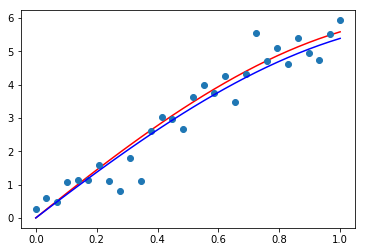

Optimization terminated successfully.
         Current function value: 10.197619
         Iterations: 58
         Function evaluations: 111
Parameters estimated with the simplex algorithm: [-0.21165887  6.97328084]


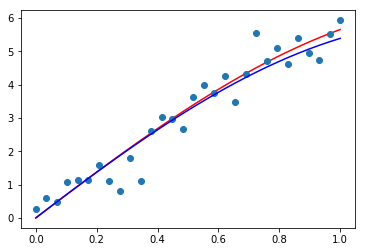

In [15]:
%matplotlib inline
import numpy as np
import pylab as plt
from scipy import optimize

nsamp = 30
x = np.linspace(0,1,nsamp)
"""
y = -0.5*x**2 + 7*sin(x)
This is what we try to fit against. Suppose we know our function is generated
by this law and want to find the (-0.5, 7) parameters. Alternatively we might
not know anything about this dataset but just want to fit this curve to it.
"""

# define the normal function
f = lambda p, x: p[0]*x*x + p[1]*np.sin(x)

testp = (-0.5, 7)
print("True(unknown) parameter value:", testp)
y = f(testp,x)
yr = y + .5*np.random.normal(size=nsamp) # adding a small noise

# define the residual function
e = lambda p, x, y: (abs((f(p,x)-y))).sum()

p0 = (5, 20) # initial parameter value
print("Initial parameter value:", p0)

# uses the standard least squares algorithm
p_est1 = optimize.least_squares(e, p0, args=(x, yr))
print("Parameters estimated with least squares:",p_est1.x)
y_est1 = f(p_est1.x, x)

plt.plot(x,y_est1,'r-', x,yr,'o', x,y,'b-')
plt.show()

# uses a simplex algorithm
p_est2 = optimize.fmin(e, p0, args=(x,yr))
print("Parameters estimated with the simplex algorithm:",p_est2)
y_est2 = f(p_est2, x)

plt.plot(x,y_est2,'r-', x,yr,'o', x,y,'b-')
plt.show()

Exercises:
- Use a different nonlinear function.
- Define a normal Python function f() instead!
- Improve the LS fit by using nonstandart loss functions (soft_l1, cauchy)
- Improve the LS fit by using different methods {‘dogbox’, ‘lm’}

## Gradient descent

Note that least squares is not an optimization method per se, it is a method to frame linear regression in the terms of an optimization problem. Gradient descent is the basis optimizatin method for most of modern machine learning, and any processor software today is judged by its speed to compute gradient descent. On GPUs, it sits as the foundation for Deep Learning and Reinforcement Learning.

The method is making an iterative walk in the direction of the local gradient, until the step size becomes :
$$\mathbf{a}_{n+1} = \mathbf{a}_n-\gamma\nabla F(\mathbf{a}_n)$$

Here is the naive algorithm, adapted from Wikipedia:

The local minimum occurs at 2.249965


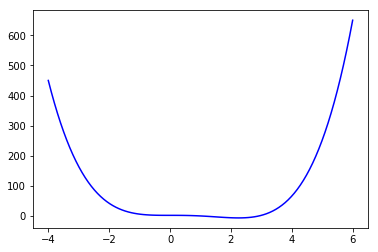

In [10]:
%matplotlib inline
import numpy as np
import pylab as plt


cur_x = 6 # The algorithm starts at x=6
gamma = 0.01 # step size multiplier
precision = 0.00001
previous_step_size = 1/precision; # some large value

f = lambda x: x**4 - 3 * x**3 + 2
df = lambda x: 4 * x**3 - 9 * x**2

x = np.linspace(-4,cur_x,100)
while previous_step_size > precision:
    prev_x = cur_x
    cur_x += -gamma * df(prev_x)
    previous_step_size = abs(cur_x - prev_x)

print("The local minimum occurs at %f" % cur_x)

plt.plot(x,f(x),'b-')

The naive implementations suffer from many downsides, from speed to oscilating accross a valey. Another typical fault of the naive approach is assuming that the functions to be optimized are smooth, with expected variation for small variations in their parameters. Here is an example of how to compute the gradient descent with scipy, for the rosenbrock function, a function known to be ill-conditioned.

But before, here is a [practical advice from Scipy](https://www.scipy-lectures.org/advanced/mathematical_optimization/index.html):

- Gradient not known:
> In general, prefer BFGS or L-BFGS, even if you have to approximate numerically gradients. These are also the default if you omit the parameter method - depending if the problem has constraints or bounds. On well-conditioned problems, Powell and Nelder-Mead, both gradient-free methods, work well in high dimension, but they collapse for ill-conditioned problems.
- With knowledge of the gradient:
> BFGS or L-BFGS. Computational overhead of BFGS is larger than that L-BFGS, itself larger than that of conjugate gradient. On the other side, BFGS usually needs less function evaluations than CG. Thus conjugate gradient method is better than BFGS at optimizing computationally cheap functions.
With the Hessian:
- If you can compute the Hessian, prefer the Newton method (Newton-CG or TCG).
- If you have noisy measurements: Use Nelder-Mead or Powell.

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 51
         Hessian evaluations: 0
[ 1.  1.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 19
         Hessian evaluations: 9
[ 1.  1.]


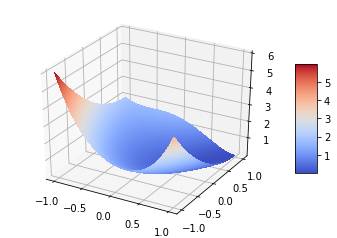

In [17]:
import numpy as np
import scipy.optimize as optimize


def f(x):   # The rosenbrock function
    return .5*(1 - x[0])**2 + (x[1] - x[0]**2)**2
def fprime(x):
    return np.array((-2*.5*(1 - x[0]) - 4*x[0]*(x[1] - x[0]**2), 2*(x[1] - x[0]**2)))
print(optimize.fmin_ncg(f, [2, 2], fprime=fprime))

def hessian(x): # Computed with sympy
    return np.array(((1 - 4*x[1] + 12*x[0]**2, -4*x[0]), (-4*x[0], 2)))
print(optimize.fmin_ncg(f, [2, 2], fprime=fprime, fhess=hessian))

%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(-1, 1, 0.005)
Y = np.arange(-1, 1, 0.005)
X, Y = np.meshgrid(X, Y)
Z = .5*(1 - X)**2 + (Y - X**2)**2
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)
#ax.set_zlim(-1000.01, 1000.01)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Constraint optimization


Problem definition:

$$
\begin{array}{rcll}
\min &~& f(\mathbf{x}) & \\
\mathrm{subject~to} &~& g_i(\mathbf{x}) = c_i &\text{for } i=1,\ldots,n \quad \text{Equality constraints} \\
 &~& h_j(\mathbf{x}) \geqq d_j &\text{for } j=1,\ldots,m \quad \text{Inequality constraints}
\end{array}
$$


Let's take the particular case when the objective function and the constraints linear, such as in the cannonical form:

$$\begin{align}
& \text{maximize}   && \mathbf{c}^\mathrm{T} \mathbf{x}\\
& \text{subject to} && A \mathbf{x} \leq \mathbf{b} \\
& \text{and} && \mathbf{x} \ge \mathbf{0}
\end{align}$$

Scipy has methods for optimizing functions under constraints, including linear programming. Aditionally many (linear or nonlinear) constraint optimization problems can be turned into full optimization problems using Lagrange multipliers. We will learn how to run linear problems with PuLP.

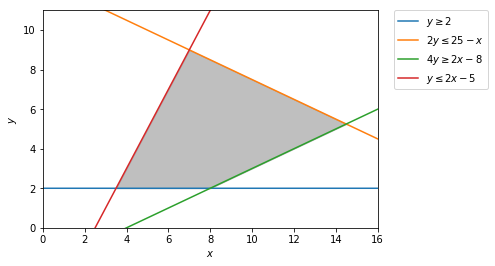

In [19]:
"""
maximize: 4x + 3y

x > 0
y >= 2

x + 2y <= 25
2x - 4y <= 8
-2x + y <= -5 
"""

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(0, 20, 2000)
y1 = (x*0) + 2
y2 = (25-x)/2.0 
y3 = (2*x-8)/4.0
y4 = 2 * x -5

# Make plot
plt.plot(x, y1, label=r'$y\geq2$')
plt.plot(x, y2, label=r'$2y\leq25-x$')
plt.plot(x, y3, label=r'$4y\geq 2x - 8$')
plt.plot(x, y4, label=r'$y\leq 2x-5$')
plt.xlim((0, 16))
plt.ylim((0, 11))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

# Fill feasible region
y5 = np.minimum(y2, y4)
y6 = np.maximum(y1, y3)
plt.fill_between(x, y5, y6, where=y5>y6, color='grey', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

The solution to an optimization problem with linear constraints lies somewhere on the gray area, and it is not necessarily unique. However for linear optimization functions the solution is on one of the vertices. Now let us frame it with PuLP:

```
conda install -c conda-forge pulp 
```


In [3]:
import pulp
my_lp_problem = pulp.LpProblem("My LP Problem", pulp.LpMaximize)

x = pulp.LpVariable('x', lowBound=0, cat='Continuous')
y = pulp.LpVariable('y', lowBound=2, cat='Continuous')

# Objective function
my_lp_problem += 4 * x + 3 * y, "Z"

# Constraints
my_lp_problem += 2 * y <= 25 - x
my_lp_problem += 4 * y >= 2 * x - 8
my_lp_problem += y <= 2 * x - 5

my_lp_problem

My LP Problem:
MAXIMIZE
4*x + 3*y + 0
SUBJECT TO
_C1: x + 2 y <= 25

_C2: - 2 x + 4 y >= -8

_C3: - 2 x + y <= -5

VARIABLES
x Continuous
2 <= y Continuous

In [5]:
my_lp_problem.solve()
print(pulp.LpStatus[my_lp_problem.status])
for variable in my_lp_problem.variables():
    print("{} = {}".format(variable.name, variable.varValue))
print(pulp.value(my_lp_problem.objective))

Optimal
x = 14.5
y = 5.25
73.75


Further complications arise when some of the constraints need to be integers, in which case the problem becomes known as Mixed Integer Liniar Programming and it computationally more expensive. Yet such problems are quite frequent, for example in metabolic engineering, where you need to deal machines operating on discrete intervals, or when studying protein folding or DNA recombination. In such cases one can also install python packages that deal with the specific problem, such as [cobrapy](https://cobrapy.readthedocs.io/en/latest/) for metabolic engineering.

Further reading:
- For LP with PuLP, I recommend this tutorial, which also uses some real life problems, and has a github link for the notebooks: [http://benalexkeen.com/linear-programming-with-python-and-pulp/](http://benalexkeen.com/linear-programming-with-python-and-pulp/)
- For a great list of LP solvers check [https://stackoverflow.com/questions/26305704/python-mixed-integer-linear-programming](https://stackoverflow.com/questions/26305704/python-mixed-integer-linear-programming)


## Global optimization

The most computation efficient optimization methods can only find local optima, while using different heuristics when needing to access global optima. In the class of global optimization algorithms a few methods to mention are:

- Grid search: These methods belong to the class of brute force or greedy searches and check for solutions in multidimensional sollution spaces. Typicall employed when having to find optimal parameter combinations for machine learning problems (hyperparametrization)
- Branch and Bound: This method, belonging to the more general class called dynamical programming, uses an optimal rooted tree, thus breaking the problem into smaller local optima problems. It is used in LP/MILP for example, or by sequence alignment programs such as BLAST.
- Monte Carlo: This method belongs to the stochastic optimization class, that instead of looking for an exact fit is using random sampling and bayesian statistics. These methods are expected to gain more traction with the evolution of computing power.
- Heuristics: Many methods in this class are nature inspired, such as genetic programming, ant colony optimization etc.

In [1]:
import sys
sys.version


'3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 18:21:58) \n[GCC 7.2.0]'

In [2]:
sys.path


['',
 '/home/sergiu/programs/miniconda3/envs/pycourse/lib/python36.zip',
 '/home/sergiu/programs/miniconda3/envs/pycourse/lib/python3.6',
 '/home/sergiu/programs/miniconda3/envs/pycourse/lib/python3.6/lib-dynload',
 '/home/sergiu/programs/miniconda3/envs/pycourse/lib/python3.6/site-packages',
 '/home/sergiu/programs/miniconda3/envs/pycourse/lib/python3.6/site-packages/IPython/extensions',
 '/home/sergiu/.ipython']